<a href="https://colab.research.google.com/github/nikitha-ramchander/Sales-Prediction/blob/main/SalesMachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [171]:
# Mount Data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [172]:
# Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import linear regression model and regression metrics  
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# Import standard scaler and knn regressor 
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
# Import TTS
from sklearn.model_selection import train_test_split
# Import bagged trees & random forest
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

In [173]:
# Load Data
sales = pd.read_csv('/content/drive/MyDrive/Coding Dojo/Project/salesdatacleaning.csv')
sales.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,No_Weight_Flag,No_Size_Flag
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,0,0
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,0,0
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,0,0
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,High,Tier 3,Grocery Store,732.3800,0,1
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,0,0


#Prepare Data Columns Before Machine Learning Models
Let's deal with the categorical varaibles by grouping them as nominal, ordinal, or numerical.

* Item Identifier: nominal
* Item Weight: numerical 
* Item Fat Content: nominal 
* Item Visibility: numerical 
* Item Type: nominal 
* Item MRP: numerical
* Outlet Identifier: nominal 
* Establishment Year: ordinal
* Outlet Size: ordinal
* Location Type: ordinal 
* Outlet Type: ordinal
* Item Sales: numerical  
* No Weight Flag: nominal
* No Size Flag: nominal

#Columns of Ordinal Variables.

In [174]:
# View unique categories of Outlet Establishment Year 
sales['Outlet_Establishment_Year'].value_counts()

1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64

In [175]:
# Define dictionary to replace 
years = {1985 : 0, 1987 : 1, 1997 : 2, 1998 : 3, 1999 : 4, 2002 : 5, 2004 : 6, 2007 : 7, 2009 : 8}

In [176]:
# Map the dictionary 
sales['Outlet_Establishment_Year'] = sales['Outlet_Establishment_Year'].map(years)
sales.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,No_Weight_Flag,No_Size_Flag
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,4,Medium,Tier 1,Supermarket Type1,3735.1380,0,0
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,8,Medium,Tier 3,Supermarket Type2,443.4228,0,0


In [177]:
# View unique categories of Outlet Size
sales['Outlet_Size'].value_counts()

Medium    4648
Small     2388
High      1487
Name: Outlet_Size, dtype: int64

In [178]:
# Define dictionary to replace 
outletsize = {'Small': 0, 'Medium': 1, 'High': 2}

In [179]:
# Map the dictionary 
sales['Outlet_Size'] = sales['Outlet_Size'].map(outletsize)
sales.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,No_Weight_Flag,No_Size_Flag
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,4,1,Tier 1,Supermarket Type1,3735.1380,0,0
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,8,1,Tier 3,Supermarket Type2,443.4228,0,0


In [180]:
# View unique categories of Outlet Location Type 
sales['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [181]:
# Define dictionary to replace 
location = {'Tier 1': 0, 'Tier 2': 1, 'Tier 3': 2}

In [182]:
# Map the dictionary 
sales['Outlet_Location_Type'] = sales['Outlet_Location_Type'].map(location)
sales.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,No_Weight_Flag,No_Size_Flag
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,4,1,0,Supermarket Type1,3735.1380,0,0
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,8,1,2,Supermarket Type2,443.4228,0,0


In [183]:
# View unique categories of Outlet Type
sales['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [184]:
# Define dictionary to replace 
outlettype = {'Supermarket Type1': 0, 'Supermarket Type2': 1, 'Supermarket Type3': 2, 'Grocery Store': 3}

In [185]:
# Map the dictionary 
sales['Outlet_Type'] = sales['Outlet_Type'].map(outlettype)
sales.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,No_Weight_Flag,No_Size_Flag
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,4,1,0,0,3735.1380,0,0
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,8,1,2,1,443.4228,0,0


#Columns of Nominal Variables

In [186]:
# Item Identifier seems too unique and will not help with modeling, I will drop this column
sales['Item_Identifier'].nunique()

1559

In [187]:
# Outlet Identifier seems too unique and will not help with modeling, I will drop this column
sales['Outlet_Identifier'].nunique()

10

In [188]:
sales.drop(columns = ['Item_Identifier', 'Outlet_Identifier'], inplace = True)
sales.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,No_Weight_Flag,No_Size_Flag
0,9.30,Low Fat,0.016047,Dairy,249.8092,4,1,0,0,3735.1380,0,0
1,5.92,Regular,0.019278,Soft Drinks,48.2692,8,1,2,1,443.4228,0,0
2,17.50,Low Fat,0.016760,Meat,141.6180,4,1,0,0,2097.2700,0,0
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,3,2,2,3,732.3800,0,1
4,8.93,Low Fat,0.000000,Household,53.8614,1,2,2,0,994.7052,0,0


In [189]:
sales = pd.get_dummies(sales, columns = ['Item_Fat_Content', 'Item_Type', 'No_Weight_Flag', 'No_Size_Flag'], drop_first = True)
sales.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,No_Weight_Flag_1,No_Size_Flag_1
0,9.30,0.016047,249.8092,4,1,0,0,3735.1380,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5.92,0.019278,48.2692,8,1,2,1,443.4228,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,17.50,0.016760,141.6180,4,1,0,0,2097.2700,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,19.20,0.000000,182.0950,3,2,2,3,732.3800,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,8.93,0.000000,53.8614,1,2,2,0,994.7052,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


Now that we have categorized each variable we can run this data frame though a few Machine Learning models! 

In [228]:
# Before running any machine learning model let's split data into features matrix and target vector 
X = sales.drop(columns = 'Item_Outlet_Sales')
y = sales['Item_Outlet_Sales']

In [191]:
# Check shape, two dimensional
X.shape

(8523, 25)

In [192]:
# Check shape, one dimensional 
y.shape

(8523,)

#Linear Regression
Linear Regression models predict the relationship between a features matrix and a target vector. It attempts to model the relationship between two variables by fitting a linear equation to observed data.

In [221]:
# Instantiate Linear Regression
reg = LinearRegression(fit_intercept = True)
# Fit model 
reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [222]:
# Predict Sales 
lr_preds = reg.predict(X)

In [225]:
# R^2: Coefficient of Determination
print('R^2:', reg.score(X, y))

R^2: 0.5093577284907114


In [224]:
# RMSE: Root Mean Squared Error 
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, lr_preds)))

Root Mean Squared Error: 1195.262231578095


#KNN Regression 
K-nearest neighbors is a model that uses the "K" most similar observations in order to make a prediction. So, it approximates the association between independent variables and the continuous outcome by averaging the observations in the same neighbourhood.

In [198]:
# Standardize data
scaler = StandardScaler()
# Fit on X
scaler.fit(X)
# Transform X
X = scaler.transform(X);

In [199]:
# Instantiate KNNRegressor
knn_reg = KNeighborsRegressor(n_neighbors=3)
knn_reg.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

In [200]:
# Predict sales
knn_preds = knn_reg.predict(X)

In [201]:
# R^2: COefficient of Determination 
print('R^2:', knn_reg.score(X, y))

R^2: 0.7202013386878403


In [202]:
# RMSE: Root Mean Squared Error 
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, knn_preds)))

Root Mean Squared Error: 902.6170475137858


# KNN Regressor with Train Test Split 
Train test split also known as model validation is a model that shows how will it will perform on new data. It's a process where a trained model is evaluated with a testing data set.

In [203]:
# Train Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 3)

In [204]:
# Standardize data
scaler = StandardScaler()
# Fit only on X_train
scaler.fit(X_train)
# Transform X
X_train = scaler.transform(X_train);
X_test = scaler.transform(X_test);

In [205]:
# Instantiate KNNRegressor
knn_tts_reg = KNeighborsRegressor(n_neighbors=3)
knn_tts_reg.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

In [206]:
# Predict sales
knn_tts_preds = knn_tts_reg.predict(X_test)

In [226]:
# R^2: COefficient of Determination 
print('Training R^2:', knn_tts_reg.score(X_train, y_train))
print('Testing R^2:', knn_tts_reg.score(X_test, y_test))

Training R^2: 0.7134003174515664
Testing R^2: 0.46140521773385634


In [208]:
# RMSE: Root Mean Squared Error 
print('Testing RMSE:', np.sqrt(mean_squared_error(y_test, knn_tts_preds)))

Testing RMSE: 1249.6471397636094


# Bagged Trees with Train Test Split 
Bagged trees uses multiple learning algorithms to obtain a better predictive performance than could be obtained from any of the individual learning algorithms (individual decision trees in this case) alone. The name bagging is short for bootstrap aggregating. 

In [209]:
# Bagged Trees Regressor
bt_tts_reg = BaggingRegressor()
bt_tts_reg.fit(X_train, y_train)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [210]:
# Predict sales
bt_tts_preds = bt_tts_reg.predict(X_test)

In [211]:
# R^2: COefficient of Determination 
print('Training R^2:', bt_tts_reg.score(X_train, y_train))
print('Testing R^2:', bt_tts_reg.score(X_test, y_test))

Training R^2: 0.9109696415136963
Testing R^2: 0.5404385825479721


In [212]:
# RMSE: Root Mean Squared Error 
print('Testing RMSE:', np.sqrt(mean_squared_error(y_test, bt_tts_preds)))

Testing RMSE: 1154.3250190741885


# Random Forests with Train Test Split
Random forests, consists of many individual decision trees that operate as an ensemble. The only difference between bagged trees and a random forest is that each time when building each tree, a random split is considered by certain features. 

In [213]:
# Random Forest regressor
rfr_tts_reg = RandomForestRegressor()
rfr_tts_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [214]:
# Predict sales
rfr_tts_preds = rfr_tts_reg.predict(X_test)

In [215]:
# R^2: COefficient of Determination 
print('Training R^2:', rfr_tts_reg.score(X_train, y_train))
print('Testing R^2:', rfr_tts_reg.score(X_test, y_test))

Training R^2: 0.9365995089662549
Testing R^2: 0.5716563757556274


Interpretation: Measure the strength of this model. The training score of 94% shows the best fit model out of all the other machine learning models. Also, the testing score is the highest at 57% compared to other models.

Units: between -1 and 1, anyting closer to 1 is the best fit model.

In [216]:
# MAE: Mean Absolute Error 
print('Mean Absolute Error:', mean_absolute_error(y_test, rfr_tts_preds))

Mean Absolute Error: 783.6428570229939


Interpretation: This is the most human interpretable metric because it shows on average how wrong the model is. In this case on average the model is wrong by 783.64 dollars. Since the spread of sales is from 0 to 10,000 it is not terrible that you are off by 783.64 dollars because it is such a large spread of sales.

Units: In dollars, on average it is off by so many dollars.

In [217]:
# MSE: Mean Squared Error 
print('Mean Squared Error:', mean_squared_error(y_test, rfr_tts_preds))

Mean Squared Error: 1241952.4374509058


Interpretation: Not the most human interpretable metric. Essentialy it "punishes" larger errors, which tends to be useful in the real world.

Units: It is in squared dollars.

In [218]:
# RMSE: Root Mean Squared Error 
print('Testing RMSE: ', np.sqrt(mean_squared_error(y_test, rfr_tts_preds)))

Testing RMSE:  1114.4291980430635


Interpretation: This is a human interpretable metric because it is squared and gets it back into the original units that we can understand. The Testing RMSE is off by 1114. 43 dollars which is more than the MAE at 783.64 dollars. The reason being, RMSE penalizes being off by more larger data points through outliers. That is why RMSE is larger than MAE because this model has quite a few outliers that this data set is significantly off by. However this model (Random Forests) had the lowest RMSE than other models which indicates better fit and suggests how accurately the model predicts a response. 

Units: Dollar amount.

In [229]:
X

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,No_Weight_Flag_1,No_Size_Flag_1
0,9.300,0.016047,249.8092,4,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5.920,0.019278,48.2692,8,1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,17.500,0.016760,141.6180,4,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,19.200,0.000000,182.0950,3,2,2,3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,8.930,0.000000,53.8614,1,2,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,6.865,0.056783,214.5218,1,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
8519,8.380,0.046982,108.1570,5,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8520,10.600,0.035186,85.1224,6,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
8521,7.210,0.145221,103.1332,8,1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


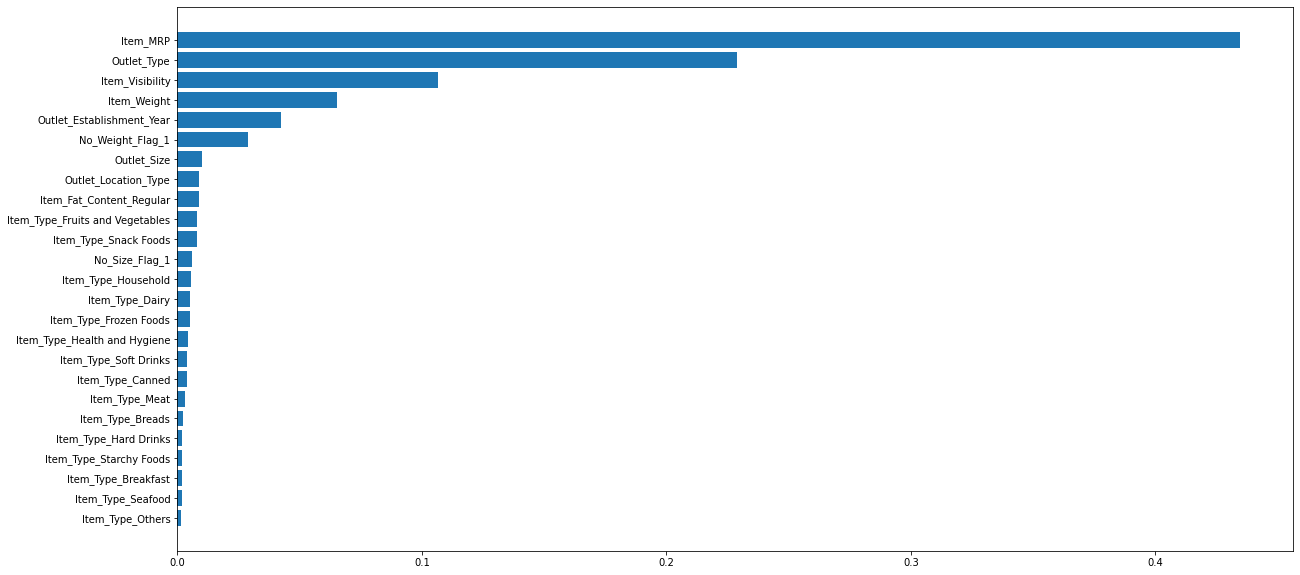

In [231]:
# Get random forest feature importances & plot top
rfr_features = pd.DataFrame({'feature': X.columns, 'feature_importance': rfr_tts_reg.feature_importances_})
rfr_features.sort_values(by = 'feature_importance', inplace = True)

plt.figure(figsize = (20, 10))
plt.barh(rf_features['feature'], rf_features['feature_importance']);

# Final Comments: 
From the five different Machine Learning Models implemented, Random Forests produced the highest R^2 and the smallest RMSE. The higher the R^2 the better the model fits your data which is at 94%. A low RMSE score is beneficial to any model because you care about the predicition accuracy including penelization of larger errors which is at 1114.43 dollars. 